In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDAS').getOrCreate()

In [2]:
Total_Clean_data = spark.read.csv('Total_Clean_data.csv', inferSchema=True, header=True)
Total_Clean_data.printSchema()

root
 |-- Rank: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- NA_Sales: double (nullable = true)
 |-- EU_Sales: double (nullable = true)
 |-- JP_Sales: double (nullable = true)
 |-- Other_Sales: double (nullable = true)
 |-- Global_Sales: double (nullable = true)
 |-- Bin_Global_Sales: double (nullable = true)



In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vector,Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression

In [4]:
Total_Clean_data = Total_Clean_data.toPandas()

In [5]:
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Action",1)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Adventure",2)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Fighting",3)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Misc",4)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Platform",5)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Puzzle",6)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Racing",7)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Role-Playing",8)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Shooter",9)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Simulation",10)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Sports",11)
Total_Clean_data["Genre"] = Total_Clean_data["Genre"].replace("Strategy",12)

In [6]:
Total_Clean_data = spark.createDataFrame(Total_Clean_data)

In [7]:
vec = VectorAssembler(inputCols=["Year","Genre",'JP_Sales',\
                                    "NA_Sales",'Rank',"Other_Sales",\
                                    "EU_Sales","Global_Sales","Bin_Global_Sales"], outputCol='features')

In [8]:
data = vec.transform(Total_Clean_data)

In [9]:
Final_data = data.select("features","Global_Sales")

In [10]:
train_data,test_data = Final_data.randomSplit([0.7, 0.3])

In [11]:
train_data.describe().show()

+-------+------------------+
|summary|      Global_Sales|
+-------+------------------+
|  count|             11394|
|   mean|0.5412234509391113|
| stddev|1.6007298636232898|
|    min|              0.01|
|    max|             82.74|
+-------+------------------+



In [12]:
test_data.describe().show()

+-------+------------------+
|summary|      Global_Sales|
+-------+------------------+
|  count|              4891|
|   mean|0.5407503578000401|
| stddev|1.4877453293035028|
|    min|              0.01|
|    max|             40.24|
+-------+------------------+



In [13]:
lr_ridge = LinearRegression(maxIter = 10,regParam = 0.3, elasticNetParam = 0, labelCol='Global_Sales')

In [14]:
lr_ridge = LinearRegression(maxIter = 10,regParam = 0.3, elasticNetParam = 0, labelCol='Global_Sales')
lr_model_ridge = lr_ridge.fit(train_data)

In [15]:
print("Coefficients:{}, Intercept:{}".format(lr_model_ridge.coefficients,lr_model_ridge.intercept))

Coefficients:[-0.001005430671698727,2.2358030576843993e-05,0.6124934111011541,0.4925850247722201,-1.704917770264037e-05,0.8637476567844935,0.5893742877277263,0.23590004598074368,0.8665522022487157], Intercept:2.2455813900638626


In [16]:
RR_Result = lr_model_ridge.evaluate(test_data) 
RR_Result.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|-0.00787408186648...|
|-0.07314447672518429|
|-0.06763029436007129|
|-0.06635987272623073|
|-0.06787561646012541|
|-0.06024733605988486|
|-0.06617908779206283|
|-0.06557803653471994|
|-0.05705886885619166|
|0.003175394510659...|
| 0.27773333948253565|
|  0.3369974874784556|
|  0.0423797087400446|
|  0.9301864099687931|
|-0.04232642348769...|
|-0.06654751945469073|
| 0.18395694903169058|
|  0.3183581518730325|
|-0.05782407895049413|
|-0.07231533805113963|
+--------------------+
only showing top 20 rows



In [17]:
predictions_lr_ridge = lr_model_ridge.transform(test_data)
predictions_lr_ridge.show()

+--------------------+------------+-------------------+
|            features|Global_Sales|         prediction|
+--------------------+------------+-------------------+
|[1980.0,3.0,0.0,0...|        0.77| 0.7778740818664862|
|[1981.0,1.0,0.0,0...|        0.22| 0.2931444767251843|
|[1981.0,1.0,0.0,0...|        0.24| 0.3076302943600713|
|[1981.0,1.0,0.0,0...|        0.33|0.39635987272623074|
|[1981.0,1.0,0.0,0...|        0.37| 0.4378756164601254|
|[1981.0,1.0,0.0,0...|        0.39| 0.4502473360598849|
|[1981.0,1.0,0.0,0...|        0.39|0.45617908779206284|
|[1981.0,1.0,0.0,0...|         0.4|0.46557803653471996|
|[1981.0,1.0,0.0,0...|        0.43|0.48705886885619165|
|[1981.0,1.0,0.0,0...|        0.82| 0.8168246054893409|
|[1981.0,1.0,0.0,1...|        1.97| 1.6922666605174643|
|[1981.0,1.0,0.0,2...|         2.2| 1.8630025125215446|
|[1981.0,5.0,0.0,0...|        0.97| 0.9276202912599554|
|[1981.0,5.0,0.0,4...|         4.5|  3.569813590031207|
|[1981.0,6.0,0.0,0...|        0.59| 0.6323264234

In [18]:
test_p = lr_model_ridge.evaluate(test_data)
test_p.r2

0.9943764656498093

In [30]:
import matplotlib.pylab as plt

<function matplotlib.pyplot.show(*args, **kw)>

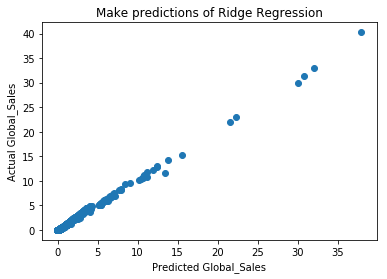

In [29]:
plt.scatter(x = predictions_lr_ridge.toPandas()["prediction"], y =  predictions_lr_ridge.toPandas()["Global_Sales"])
plt.title("Make predictions of Ridge Regression")
plt.xlabel("Predicted Global_Sales")
plt.ylabel("Actual Global_Sales")
plt.show